# Sentinel 2 binary classification with UNET 

Base code (UNET model, some utils) were taken from aladdinpersson from github. Thanks for sharing it!

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet

Import libraries

In [1]:
# get torch functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.autograd.profiler

# get image process functions
import cv2
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from scipy import ndimage

# get linear algebra, vis, preprocess 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# get UNET and Focal loss
from model_struct import *
from torchvision.ops import sigmoid_focal_loss

# get subshell functions
from glob import glob
import os, sys

D:\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

Define dataset

In [2]:

IMAGE_HEIGHT = 201
IMAGE_WIDTH = 201
TRAIN_IMG_DIR = "/585_db/train_images/"
TRAIN_LBL_DIR = "/585_db/train_labels/"
TEST_IMG_DIR = "/585_db/test_images/"
TEST_LBL_DIR = "/585_db/test_labels/"
root = "somepath/Unet_binary"

class simple_segmentDS(torch.utils.data.Dataset):        
    def __init__(self, root, imdir, lbldir, training=False, transform=None):
            super(simple_segmentDS, self).__init__()
            self.root = root
            self.imdir = imdir
            self.lbldir = lbldir
            self.training = training
            self.transform = transform
            self.IMG_NAMES = sorted(glob(self.root + self.imdir + '*.jpg'))
            self.LBL_NAMES = sorted(glob(self.root + self.lbldir + '*.png'))
            
    def __len__(self):
        return len(self.IMG_NAMES)

    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = self.LBL_NAMES[idx]        
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) 
        cls_mask = mask.copy()
        cls_mask[cls_mask[:][:]==2] = 0  # because the original samples were classified as 1 forest, 2 bg   
                                         # so here i make it binary by 1 forest 0 bg
        
        if self.training == True:
            if self.transform is not None:
                image = transforms.functional.to_pil_image(image)
                image = self.transform(image)
                image = np.array(image)
            
            # No real usage rotating the images (cuz its satellite image) !?
            
            ## 90 degree rotation
            #if np.random.rand()<0.5:
            #    angle = np.random.randint(4) * 90
            #    image = ndimage.rotate(image,angle,reshape=True)
            #    cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)
    
            ## vertical flip
            #if np.random.rand()<0.5:
            #    image = np.flip(image, 0)
            #    cls_mask = np.flip(cls_mask, 0)
                
            ## horizonal flip
            #if np.random.rand()<0.5:
            #    image = np.flip(image, 1)
            #    cls_mask = np.flip(cls_mask, 1)
    
        image = cv2.resize(image, (201,201))/255.0
        cls_mask = cv2.resize(cls_mask, (201,201)) 
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.float32)

In [4]:
# Some additional transform
color_shift = transforms.ColorJitter(.1,.1,.1,.1) # Randomly change the brightness, contrast, saturation
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))
t = transforms.Compose([color_shift, blurriness])


# Create dataloader
train_dataset = simple_segmentDS(root, TRAIN_IMG_DIR, TRAIN_LBL_DIR, training=True, transform=t)
test_dataset = simple_segmentDS(root, TEST_IMG_DIR, TEST_LBL_DIR, training=False, transform=t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True)  # contains: 468 im, mask
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=9, shuffle=False)    # contains: 117 im,mask


In [5]:
print(test_dataset[3][0].shape)

torch.Size([3, 201, 201])


torch.Size([3, 201, 201])
torch.Size([201, 201])


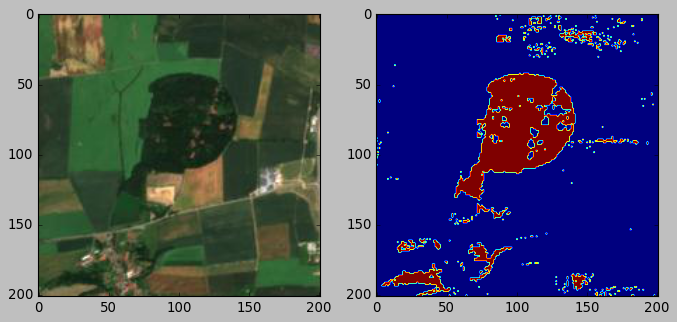

In [6]:
#Check out an example
plt.style.use('classic')
plt.figure(figsize=(10,10))

#Preparing plot
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(test_dataset[116][0].numpy(),0,-1))  # test_dataset[1][0] -- [1] means second tuple from the batch, [0/1] take the image/label 

plt.subplot(1,2,2)
lbl = test_dataset[116][1]
plt.imshow(lbl.numpy())

#Check out shape, type
print(test_dataset[116][0].shape)
print(test_dataset[116][1].shape)


# Training procedure

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001

model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) # (step_size=epoch), gamma= at every step_size we take lr * gamma


In [15]:
N_EPOCHS = 8
n_total_batch_tr = len(train_loader)
n_total_batch_val = len(test_loader)
prev_val_loss = np.Inf
plot_losses = []

with torch.autograd.profiler.profile(use_cuda=False) as time_spent:  
    for epoch in range(N_EPOCHS):

        model.train() 
        print(f'----- {epoch+1}. Training started. -----')
        loss_list = []

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = sigmoid_focal_loss(outputs, labels, alpha=0.25, gamma=3)

            # Backward and optimize
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            # Collect loss
            current_loss = loss.mean().detach().numpy()
            loss_list.append(current_loss)       

            if (i+1) % 4 == 0:
                print(f'Epoch: [{epoch+1}/{N_EPOCHS}], Batch: [{i+1}/{n_total_batch_tr}], Loss: [{current_loss:.4f}]')

        print('----- Training finished. -----')
        print()

        #----------------------------------------------------------------------------------------------

        model.eval()
        print('----- Validation started. -----')
        val_loss_list = []

        for i, (images, labels) in enumerate(test_loader):
            with torch.no_grad(): 
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)  
                val_loss = sigmoid_focal_loss(outputs, labels, alpha=0.25, gamma=3)
                current_val_loss = val_loss.mean().detach().numpy()
                val_loss_list.append(current_val_loss)

            print(f'Epoch: [{epoch+1}/{N_EPOCHS}], Batch: [{i+1}/{n_total_batch_val}], Loss: [{current_val_loss:.4f}]')
            
        print(f'----- End of validation step. Average results: -----')
        print(f'Train epoch mean loss: {np.mean(loss_list):.4f} -- Val epoch mean loss: {np.mean(val_loss_list):.4f}') 

        plot_losses.append([epoch+1, np.mean(loss_list), np.mean(val_loss_list)])

        # Compare losses, change LR
        if np.mean(val_loss_list) <= prev_val_loss:
            print(f"Lower mean loss achieved in validation ({prev_val_loss}-->{np.mean(val_loss_list):.4f}). Saving model...")
            torch.save(model.state_dict(),'./585_db/saved_model/model_at_epoch_{}_{:.5f}.pt'.format(epoch+1,np.mean(val_loss_list)))            
            prev_val_loss = np.mean(val_loss_list)
            
        # Update LR
        scheduler.step()
        print(f"LR for next epoch: {optimizer.param_groups[0]['lr']}")
        print()

#Print training time
timerange = (time_spent.self_cpu_time_total)/60000000
print(f'Total time spent: ~{timerange:.2f} min.')


----- 1. Training started. -----
Epoch: [1/8], Batch: [4/52], Loss: [0.0796]
Epoch: [1/8], Batch: [8/52], Loss: [0.0426]
Epoch: [1/8], Batch: [12/52], Loss: [0.0200]
Epoch: [1/8], Batch: [16/52], Loss: [0.0201]
Epoch: [1/8], Batch: [20/52], Loss: [0.0191]
Epoch: [1/8], Batch: [24/52], Loss: [0.0164]
Epoch: [1/8], Batch: [28/52], Loss: [0.0198]
Epoch: [1/8], Batch: [32/52], Loss: [0.0220]
Epoch: [1/8], Batch: [36/52], Loss: [0.0166]
Epoch: [1/8], Batch: [40/52], Loss: [0.0168]
Epoch: [1/8], Batch: [44/52], Loss: [0.0195]
Epoch: [1/8], Batch: [48/52], Loss: [0.0166]
Epoch: [1/8], Batch: [52/52], Loss: [0.0178]
----- Training finished. -----

----- Validation started. -----
Epoch: [1/8], Batch: [1/13], Loss: [0.0225]
Epoch: [1/8], Batch: [2/13], Loss: [0.0268]
Epoch: [1/8], Batch: [3/13], Loss: [0.0271]
Epoch: [1/8], Batch: [4/13], Loss: [0.0286]
Epoch: [1/8], Batch: [5/13], Loss: [0.0191]
Epoch: [1/8], Batch: [6/13], Loss: [0.0201]
Epoch: [1/8], Batch: [7/13], Loss: [0.0222]
Epoch: [1/8]

D:\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: [2/8], Batch: [4/52], Loss: [0.0187]
Epoch: [2/8], Batch: [8/52], Loss: [0.0126]
Epoch: [2/8], Batch: [12/52], Loss: [0.0163]
Epoch: [2/8], Batch: [16/52], Loss: [0.0146]
Epoch: [2/8], Batch: [20/52], Loss: [0.0154]
Epoch: [2/8], Batch: [24/52], Loss: [0.0165]
Epoch: [2/8], Batch: [28/52], Loss: [0.0250]
Epoch: [2/8], Batch: [32/52], Loss: [0.0244]
Epoch: [2/8], Batch: [36/52], Loss: [0.0192]
Epoch: [2/8], Batch: [40/52], Loss: [0.0145]
Epoch: [2/8], Batch: [44/52], Loss: [0.0146]
Epoch: [2/8], Batch: [48/52], Loss: [0.0225]
Epoch: [2/8], Batch: [52/52], Loss: [0.0178]
----- Training finished. -----

----- Validation started. -----
Epoch: [2/8], Batch: [1/13], Loss: [0.0160]
Epoch: [2/8], Batch: [2/13], Loss: [0.0195]
Epoch: [2/8], Batch: [3/13], Loss: [0.0192]
Epoch: [2/8], Batch: [4/13], Loss: [0.0211]
Epoch: [2/8], Batch: [5/13], Loss: [0.0143]
Epoch: [2/8], Batch: [6/13], Loss: [0.0166]
Epoch: [2/8], Batch: [7/13], Loss: [0.0158]
Epoch: [2/8], Batch: [8/13], Loss: [0.0113]
E

Epoch: [7/8], Batch: [10/13], Loss: [0.0057]
Epoch: [7/8], Batch: [11/13], Loss: [0.0141]
Epoch: [7/8], Batch: [12/13], Loss: [0.0452]
Epoch: [7/8], Batch: [13/13], Loss: [0.0163]
----- End of validation step. Average results: -----
Train epoch mean loss: 0.0166 -- Val epoch mean loss: 0.0165
LR for next epoch: 0.001

----- 8. Training started. -----
Epoch: [8/8], Batch: [4/52], Loss: [0.0161]
Epoch: [8/8], Batch: [8/52], Loss: [0.0133]
Epoch: [8/8], Batch: [12/52], Loss: [0.0222]
Epoch: [8/8], Batch: [16/52], Loss: [0.0176]
Epoch: [8/8], Batch: [20/52], Loss: [0.0145]
Epoch: [8/8], Batch: [24/52], Loss: [0.0195]
Epoch: [8/8], Batch: [28/52], Loss: [0.0161]
Epoch: [8/8], Batch: [32/52], Loss: [0.0145]
Epoch: [8/8], Batch: [36/52], Loss: [0.0155]
Epoch: [8/8], Batch: [40/52], Loss: [0.0143]
Epoch: [8/8], Batch: [44/52], Loss: [0.0170]
Epoch: [8/8], Batch: [48/52], Loss: [0.0176]
Epoch: [8/8], Batch: [52/52], Loss: [0.0138]
----- Training finished. -----

----- Validation started. -----


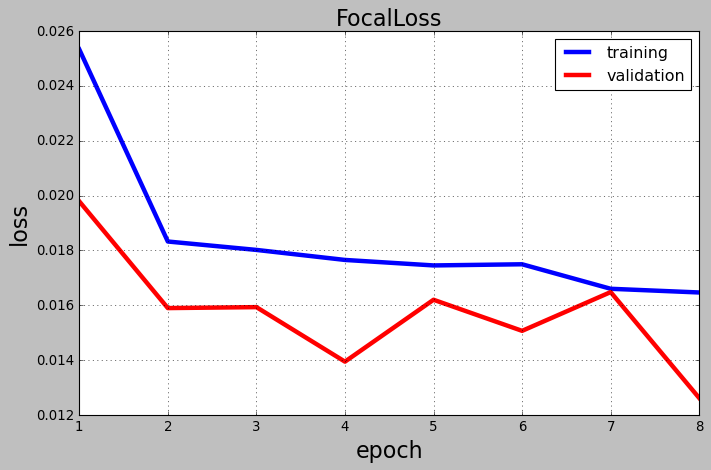

In [16]:
# Plot each epoch losses
plot_losses = np.array(plot_losses)
plt.figure(figsize=(10,6))
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

In [17]:

def check_accuracy(loader, model, device="cpu"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} pixels (9 batch with 13 image each) with accuracy {num_correct/num_pixels*100:.2f}%."
    )
    print(f"Dice score: {dice_score/len(loader):.4f}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="./585_db/saved_preds/", device="cpu"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        y = y.to(device=device).unsqueeze(1)
        for j in range(len(x)):    
            with torch.no_grad():
                preds = torch.sigmoid(model(x[j:j+1]))
                preds = (preds > 0.5).float()
            torchvision.utils.save_image(preds, f"{folder}/pred_{idx}_{j}.png")
            torchvision.utils.save_image(y[j], f"{folder}/origi_{idx}_{j}.png")

    model.train()

In [18]:
# check accuracy
check_accuracy(test_loader, model)

# print some examples to a folder
save_predictions_as_imgs(test_loader, model)

Got 4255612/4726917 pixels (9 batch with 13 image each) with accuracy 90.03%.
Dice score: 0.7774
